# Model validation

In [1]:
!hostname
!python -c "import jax; print(jax.default_backend(), jax.devices())"
# !nvidia-smi
# numpyro.set_platform("gpu")

import os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.33' # NOTE: jax preallocates GPU (default 75%)

import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp

import numpyro
from numpyro.handlers import seed, condition, trace

%matplotlib inline
%load_ext autoreload 
%autoreload 2

nid001549


gpu [cuda(id=0)]


## Render model

In [2]:
from montecosmo.models import forward_model, model_kwargs
model_kwargs['trace_deterministic'] = True
model_kwargs['scale_factor_lpt'] = 0.5
model_kwargs['scale_factor_obs'] = 0.5
model_kwargs['mesh_size'] = np.array([8,8,8])
print(f"{model_kwargs=}")

# Print infos
cell_lengths = list( model_kwargs['box_size'] / model_kwargs['mesh_size'] )
print(f"{cell_lengths=} Mpc/h")

k_nyquist = 2 * jnp.pi * jnp.min(model_kwargs['mesh_size'] / model_kwargs['box_size']) / 2
delta_k = 2 * jnp.pi * jnp.min(1 / model_kwargs['box_size']) 
# (2\pi factor because of Fourier transform definition)
print(f"{k_nyquist=:.5f} h/Mpc, {delta_k=:.5f} h/Mpc")

mean_galaxy_cell_intensity = model_kwargs['galaxy_density'] * model_kwargs['box_size'].prod() / model_kwargs['mesh_size'].prod()
print(f"{mean_galaxy_cell_intensity=:.3f} galaxy/cell")

# Render model
numpyro.render_model(model=forward_model, model_kwargs=model_kwargs, render_distributions=True, render_params=True)

/global/u1/h/hsimfroy/workspace/src/montecosmo/montecosmo/bricks.py:55: SyntaxWarning: invalid escape sequence '\d'
  """


model_kwargs={'mesh_size': array([8, 8, 8]), 'box_size': array([640, 640, 640]), 'scale_factor_lpt': 0.5, 'scale_factor_obs': 0.5, 'galaxy_density': 0.001, 'trace_reparam': True, 'trace_deterministic': True}
cell_lengths=[80.0, 80.0, 80.0] Mpc/h
k_nyquist=0.03927 h/Mpc, delta_k=0.00982 h/Mpc
mean_galaxy_cell_intensity=512.000 galaxy/cell


/global/u1/h/hsimfroy/miniforge3/envs/montecosmoenv/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/global/u1/h/hsimfroy/miniforge3/envs/montecosmoenv/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/global/u1/h/hsimfroy/miniforge3/envs/montecosmoenv/

ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

## Simulate fiducial

In [3]:
# Cosmological parameters
cosmo_var_names = ['Omega_c', 'sigma8']
cosmo_var_labels = [r'\Omega_c', r'\sigma_8']
# TODO: dict name:(mean, var) or (min,max) for cosmo_prior?

# Condition model on some cosmology and sample
fiducial_cosmo_params_base = {var_name+"_base": 0. for var_name in cosmo_var_names}
fiducial_model = condition(forward_model, fiducial_cosmo_params_base) # NOTE: Only condition on random sites, not deterministic ones
fiducial_model_trace = trace(seed(fiducial_model, rng_seed=0)).get_trace(**model_kwargs)

# Check cosmology
fiducial_cosmo_params = {var_name: fiducial_model_trace[var_name]['value'] for var_name in cosmo_var_names}
from jax_cosmo import Planck15
fiducial_cosmology = Planck15(**fiducial_cosmo_params)
print(f"Fiducial {fiducial_cosmology}")

/global/u1/h/hsimfroy/miniforge3/envs/montecosmoenv/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


Fiducial Cosmological parameters: 
    h:        0.6774 
    Omega_b:  0.0486 
    Omega_c:  0.25 
    Omega_k:  0.0 
    w0:       -1.0 
    wa:       0.0 
    n:        0.9667 
    sigma8:   0.831


# Pk test

In [105]:
from jaxpm.kernels import fftk
from scipy.special import legendre

def _my_initialize_pk(mesh_size, box_size, kmin, dk, los):

    W = np.empty(mesh_size, dtype='f4')
    W[...] = 2.0
    W[..., 0] = 1.0
    W[..., -1] = 1.0

    kmax = np.pi * np.min(np.array(mesh_size)) / np.max(np.array(box_size)) + dk / 2
    kedges = np.arange(kmin, kmax, dk)

    kshapes = np.eye(len(mesh_size), dtype='int') * -2 + 1
    kvec = [2 * np.pi *np.fft.fftfreq(m, l / m).reshape(kshape)
            for m, l, kshape in zip(mesh_size, box_size, kshapes)]
    kmesh = sum(ki**2 for ki in kvec)**0.5

    mumesh = sum(ki*losi for ki, losi in zip(kvec, los))
    kmesh_todiv = np.copy(kmesh)
    kmesh_todiv[kmesh_todiv == 0] = jnp.inf
    mumesh = mumesh / kmesh_todiv
    
    dig = np.digitize(kmesh.reshape(-1), kedges)
    Nsum = np.bincount(dig, weights=W.reshape(-1), minlength=len(kedges)+1)

    Nsum2, bin_edges = np.histogram(kmesh.reshape(-1), bins=kedges, weights=W.reshape(-1))
    print(bin_edges, kedges)
    print(Nsum, Nsum2)

    return dig, Nsum, W, kedges, mumesh


def my_power_spectrum(field, kmin, dk, box_size, los=jnp.array([0,0,1]), multipole=[0]):
    # Initialize values related to powerspectra (mode bins and weights)
    mesh_size = field.shape
    dig, Nsum, W, kedges, mumesh = _my_initialize_pk(mesh_size, box_size, kmin, dk, los)

    # Absolute value of FFT
    fft_image = jnp.fft.fftn(field)
    pk = jnp.real(fft_image * jnp.conj(fft_image)) # XXX: if real then why imag?

    # Calculating powerspectra
    imag = jnp.imag(pk)
    real = jnp.real(pk)
    Psum = np.empty((len(multipole), *Nsum.shape))
    for ell in multipole:
        imag_weights = W * imag * legendre(ell)(mumesh)
        real_weights = W * real * legendre(ell)(mumesh)
        Psum[ell] = jnp.bincount(dig, weights=imag_weights.reshape(-1), length=kedges.size+1) * 1j
        Psum[ell]+= jnp.bincount(dig, weights=real_weights.reshape(-1), length=kedges.size+1)

    print(Psum.shape, Nsum.shape)

    # Normalization for powerspectra
    P = (Psum / Nsum)[:,1:-1] * np.prod(box_size) # XXX: why not square?
    norm = np.prod(mesh_size)**2

    # Find central values of each bin
    kbins = kedges[:-1] + (kedges[1:] - kedges[:-1]) / 2

    return kbins, P / norm

In [106]:
from jaxpm.utils import power_spectrum
from jaxpm.painting import cic_paint, cic_read, compensate_cic
from montecosmo.bricks import linear_pk_interp

# # Get meshes from model trace
# init_mesh = fiducial_model_trace['init_mesh']['value']
# biased_mesh = fiducial_model_trace['biased_mesh']['value']
# obs_mesh = fiducial_model_trace['obs_mesh']['value']
# # Get other meshes from model trace particles, compensate for CIC painting convolution
# zeros_mesh = jnp.zeros(model_kwargs['mesh_size'])
# lpt_mesh = cic_paint(zeros_mesh, fiducial_model_trace['lpt_part']['value'])
# rsd_mesh = cic_paint(zeros_mesh, fiducial_model_trace['rsd_part']['value'])

# # Compute power spectra
# pk_lin_init = linear_pk_interp(fiducial_cosmology)
# pk_lin_lpt = linear_pk_interp(fiducial_cosmology, scale_factor=model_kwargs['scale_factor_lpt'])
# pk_lin_obs = linear_pk_interp(fiducial_cosmology, scale_factor=model_kwargs['scale_factor_obs'])

multipole = [0,1,2]
pk_init2 = my_power_spectrum(init_mesh, kmin=0.001, dk=0.01, box_size=model_kwargs['box_size'], multipole=multipole)
# pk_lpt2 = my_power_spectrum(compensate_cic(lpt_mesh), kmin=0.001, dk=0.01, box_size=model_kwargs['box_size'], multipole=multipole)
# pk_rsd2 = my_power_spectrum(compensate_cic(rsd_mesh), kmin=0.001, dk=0.01, box_size=model_kwargs['box_size'], multipole=multipole)
# pk_biased2 = my_power_spectrum(compensate_cic(biased_mesh), kmin=0.001, dk=0.01, box_size=model_kwargs['box_size'], multipole=multipole)

[0.001 0.011 0.021 0.031 0.041] [0.001 0.011 0.021 0.031 0.041]
[  1.   7.  36. 148. 290. 414.] [  7.  36. 148. 290.]
(3, 6) (6,)


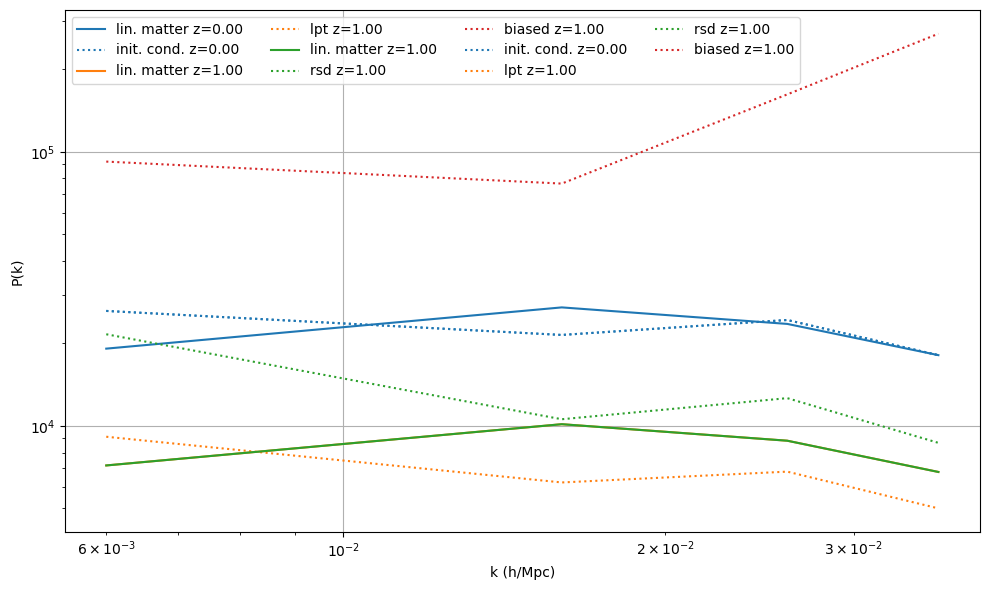

In [113]:
plt.figure(figsize=(10,6))
plt.loglog(pk_init[0], pk_lin_init(pk_init[0]), 'C0', label=f"lin. matter z={1/1-1:.2f}")
plt.loglog(pk_init[0], pk_init[1], 'C0:', label=f"init. cond. z={1/1-1:.2f}")
plt.loglog(pk_init[0], pk_lin_lpt(pk_init[0]), 'C1', label=f"lin. matter z={1/model_kwargs['scale_factor_lpt']-1:.2f}")
plt.loglog(pk_lpt[0], pk_lpt[1], 'C1:', label=f"lpt z={1/model_kwargs['scale_factor_lpt']-1:.2f}")
plt.loglog(pk_init[0], pk_lin_obs(pk_init[0]), 'C2', label=f"lin. matter z={1/model_kwargs['scale_factor_obs']-1:.2f}")
plt.loglog(pk_rsd[0], pk_rsd[1], 'C2:', label=f"rsd z={1/model_kwargs['scale_factor_obs']-1:.2f}")
plt.loglog(pk_biased[0], pk_biased[1], 'C3:', label=f"biased z={1/model_kwargs['scale_factor_obs']-1:.2f}")

plt.loglog(pk_init2[0], pk_init2[1], 'C0:', label=f"init. cond. z={1/1-1:.2f}")
plt.loglog(pk_lpt2[0], pk_lpt2[1], 'C1:', label=f"lpt z={1/model_kwargs['scale_factor_lpt']-1:.2f}")
plt.loglog(pk_rsd2[0], pk_rsd2[1], 'C2:', label=f"rsd z={1/model_kwargs['scale_factor_obs']-1:.2f}")
plt.loglog(pk_biased2[0], pk_biased2[1], 'C3:', label=f"biased z={1/model_kwargs['scale_factor_obs']-1:.2f}")
plt.grid(), plt.legend(ncols=4), plt.xlabel("k (h/Mpc)"), plt.ylabel("P(k)")
plt.tight_layout(), plt.show();

## Power spectra

In [7]:
from jaxpm.utils import power_spectrum
from jaxpm.painting import cic_paint, cic_read, compensate_cic
from montecosmo.bricks import linear_pk_interp

# Get meshes from model trace
init_mesh = fiducial_model_trace['init_mesh']['value']
biased_mesh = fiducial_model_trace['biased_mesh']['value']
obs_mesh = fiducial_model_trace['obs_mesh']['value']
# Get other meshes from model trace particles, compensate for CIC painting convolution
zeros_mesh = jnp.zeros(model_kwargs['mesh_size'])
lpt_mesh = cic_paint(zeros_mesh, fiducial_model_trace['lpt_part']['value'])
rsd_mesh = cic_paint(zeros_mesh, fiducial_model_trace['rsd_part']['value'])

# Compute power spectra
pk_lin_init = linear_pk_interp(fiducial_cosmology)
pk_lin_lpt = linear_pk_interp(fiducial_cosmology, scale_factor=model_kwargs['scale_factor_lpt'])
pk_lin_obs = linear_pk_interp(fiducial_cosmology, scale_factor=model_kwargs['scale_factor_obs'])

pk_init = power_spectrum(init_mesh, kmin=0.001, dk=0.01, boxsize=model_kwargs['box_size'])
pk_lpt = power_spectrum(compensate_cic(lpt_mesh), kmin=0.001, dk=0.01, boxsize=model_kwargs['box_size'])
pk_rsd = power_spectrum(compensate_cic(rsd_mesh), kmin=0.001, dk=0.01, boxsize=model_kwargs['box_size'])
pk_biased = power_spectrum(compensate_cic(biased_mesh), kmin=0.001, dk=0.01, boxsize=model_kwargs['box_size'])

/global/u1/h/hsimfroy/miniforge3/envs/montecosmoenv/lib/python3.12/site-packages/jax/_src/lax/lax.py:516: ComplexWarning: Casting complex values to real discards the imaginary part
  return _convert_element_type(operand, new_dtype, weak_type=False)


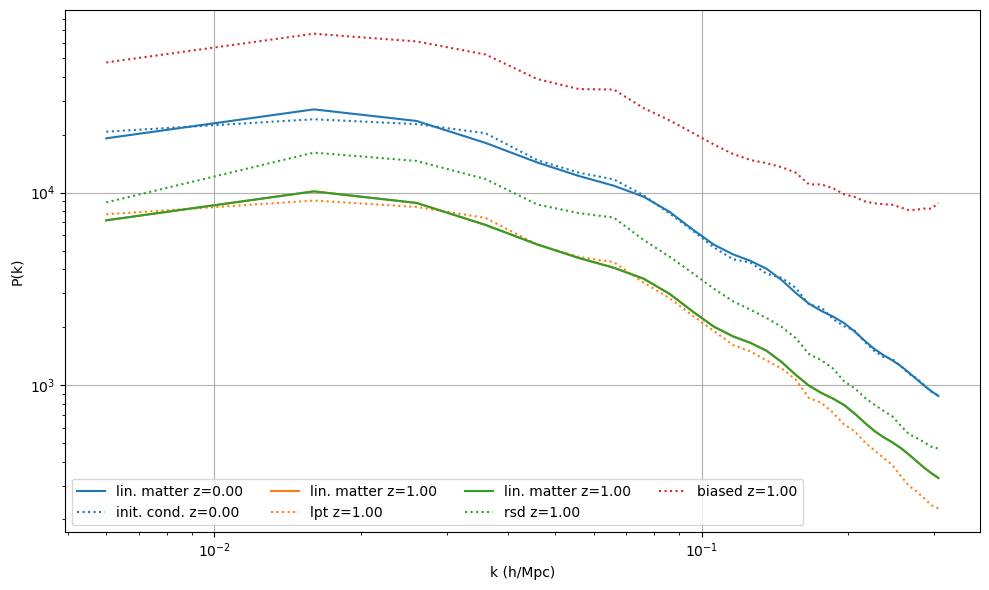

In [ ]:
plt.figure(figsize=(10,6))
plt.loglog(pk_init[0], pk_lin_init(pk_init[0]), 'C0', label=f"lin. matter z={1/1-1:.2f}")
plt.loglog(pk_init[0], pk_init[1], 'C0:', label=f"init. cond. z={1/1-1:.2f}")
plt.loglog(pk_init[0], pk_lin_lpt(pk_init[0]), 'C1', label=f"lin. matter z={1/model_kwargs['scale_factor_lpt']-1:.2f}")
plt.loglog(pk_lpt[0], pk_lpt[1], 'C1:', label=f"lpt z={1/model_kwargs['scale_factor_lpt']-1:.2f}")
plt.loglog(pk_init[0], pk_lin_obs(pk_init[0]), 'C2', label=f"lin. matter z={1/model_kwargs['scale_factor_obs']-1:.2f}")
plt.loglog(pk_rsd[0], pk_rsd[1], 'C2:', label=f"rsd z={1/model_kwargs['scale_factor_obs']-1:.2f}")
plt.loglog(pk_biased[0], pk_biased[1], 'C3:', label=f"biased z={1/model_kwargs['scale_factor_obs']-1:.2f}")
plt.grid(), plt.legend(ncols=4), plt.xlabel("k (h/Mpc)"), plt.ylabel("P(k)")
plt.tight_layout(), plt.show();

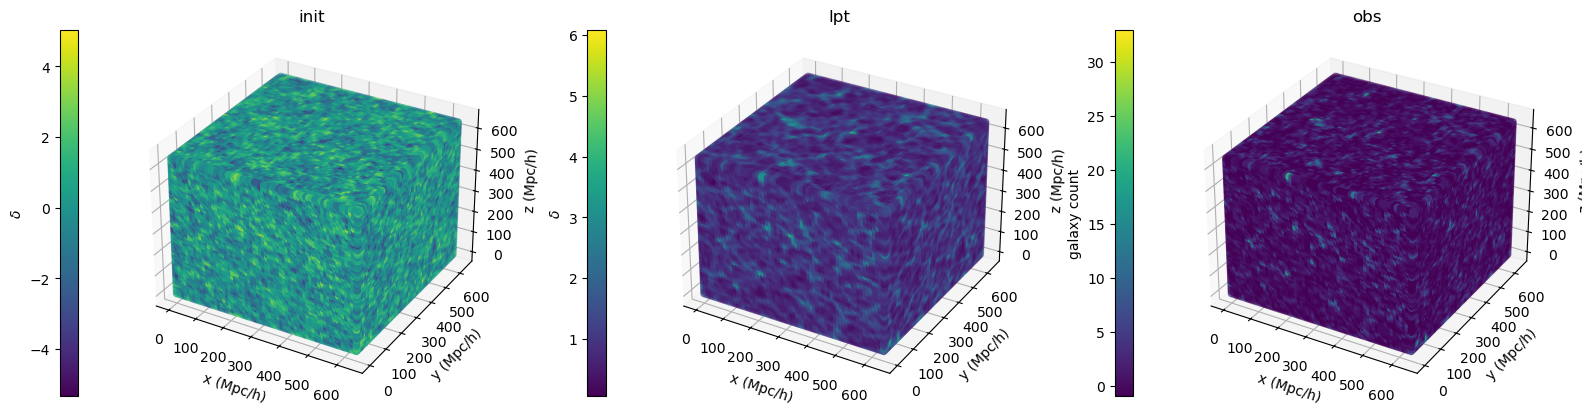

In [7]:
plt.figure(figsize=(16,4))
# # xx, yy, zz = np.indices(cmb_mesh.shape) # to get indices
xx, yy, zz = np.mgrid[[slice(0,box_length,init_mesh.shape[i]*1j) 
                       for i, box_length in enumerate(model_kwargs['box_size'])]] # to get distances
cmap = plt.colormaps['viridis']

ax3D = plt.subplot(131, projection='3d')
p3d = ax3D.scatter(xx, yy, zz, marker ="o", c=init_mesh, cmap=cmap)
ax3D.set_xlabel("x (Mpc/h)"), ax3D.set_ylabel("y (Mpc/h)"), ax3D.set_zlabel("z (Mpc/h)")
plt.colorbar(p3d, location='left').set_label(r"$\delta$")
plt.title("init")

ax3D = plt.subplot(132, projection='3d')
p3d = ax3D.scatter(xx, yy, zz, marker ="o", c=lpt_mesh, cmap=cmap)
ax3D.set_xlabel("x (Mpc/h)"), ax3D.set_ylabel("y (Mpc/h)"), ax3D.set_zlabel("z (Mpc/h)")
plt.colorbar(p3d, location='left').set_label(r"$\delta$")
plt.title("lpt")

ax3D = plt.subplot(133, projection='3d')
p3d = ax3D.scatter(xx, yy, zz, marker ="o", c=obs_mesh, cmap=cmap)
ax3D.set_xlabel("x (Mpc/h)"), ax3D.set_ylabel("y (Mpc/h)"), ax3D.set_zlabel("z (Mpc/h)")
plt.colorbar(p3d, location='left').set_label(r"galaxy count")
plt.title("obs")
# ax3D.set_box_aspect(None, zoom=0.8)

plt.tight_layout(), plt.show();

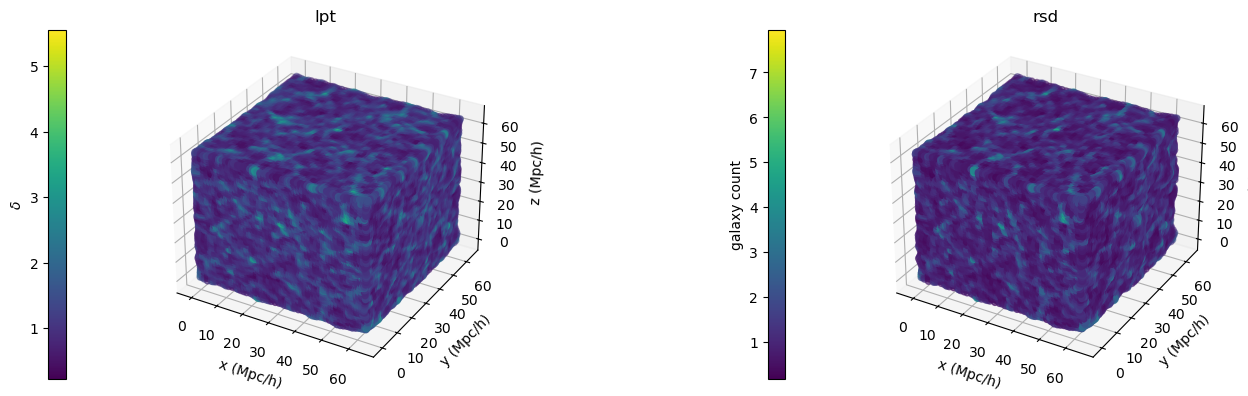

In [8]:
%matplotlib inline
plt.figure(figsize=(16,4))
cmap = plt.colormaps['viridis']

ax3D = plt.subplot(121, projection='3d')
pos = fiducial_model_trace['lpt_part']['value']
p3d = ax3D.scatter(pos[:,0], pos[:,1], pos[:,2], marker ="o", c=cic_read(lpt_mesh, pos))
ax3D.set_xlabel("x (Mpc/h)"), ax3D.set_ylabel("y (Mpc/h)"), ax3D.set_zlabel("z (Mpc/h)")
plt.colorbar(p3d, location='left').set_label(r"$\delta$")
plt.title("lpt")

ax3D = plt.subplot(122, projection='3d')
pos = fiducial_model_trace['rsd_part']['value']
p3d = ax3D.scatter(pos[:,0], pos[:,1], pos[:,2], marker ="o", c=cic_read(rsd_mesh, pos))
ax3D.set_xlabel("x (Mpc/h)"), ax3D.set_ylabel("y (Mpc/h)"), ax3D.set_zlabel("z (Mpc/h)")
plt.colorbar(p3d, location='left').set_label(r"galaxy count")
plt.title("rsd")

plt.tight_layout(), plt.show();